In [1]:
import mgclient
import torch

conn = mgclient.connect(host="localhost", port=7687)
cursor = conn.cursor()

subject_map = {
    'Case_Based': 0,
    'Genetic_Algorithms': 1,
    'Neural_Networks': 2,
    'Probabilistic_Methods': 3,
    'Reinforcement_Learning': 4,
    'Rule_Learning': 5,
    'Theory': 6
}

cursor.execute("MATCH (n) RETURN n.features, n.subject")
r_node_properties = cursor.fetchall()
x = torch.tensor([x[0] for x in r_node_properties], dtype=torch.float32)
y = torch.tensor([subject_map.get(x[1], 7) for x in r_node_properties])

cursor.execute("MATCH (n)-[r]->(m) RETURN n.id, type(r), m.id")
r_edge_index = cursor.fetchall()
edge_index = torch.tensor([(n1, n2) for (n1, r, n2) in r_edge_index], dtype=torch.long).t().contiguous()

In [2]:
edge_index

tensor([[  31349,  686532, 1129442,  ...,  928873,   15076, 1111265],
        [  31336,   31336,   31336,  ...,   24043,   24043,   24043]])

In [3]:
unique_values, indices_edge_index = torch.unique(edge_index, return_inverse=True)

print(indices_edge_index)

tensor([[ 463, 1802, 2390,  ..., 1886,  278, 2094],
        [ 462,  462,  462,  ...,  376,  376,  376]])


In [4]:
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit

data = Data(x=x, y=y, edge_index=indices_edge_index)
data = RandomNodeSplit('random', num_train_per_class=20)(data)

In [5]:
sum(data.train_mask), sum(data.val_mask), sum(data.test_mask)

(tensor(140), tensor(500), tensor(1000))

In [6]:
from torch_geometric.nn import Node2Vec
from torch.optim import SparseAdam

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Node2Vec(
    data.edge_index, 
    embedding_dim=256, 
    walk_length=5,
    context_size=5, 
    walks_per_node=30, 
    num_negative_samples=1,
    sparse=True
    ).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=8)
optimizer = SparseAdam(model.parameters(), lr=0.01)

In [7]:
for epoch in range(1, 101):
    model.train()

    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print('Epoch: {:02d}, Loss: {:.4f}'.format(epoch, total_loss / len(loader)))

Epoch: 01, Loss: 12.7508
Epoch: 02, Loss: 9.9096
Epoch: 03, Loss: 8.7103
Epoch: 04, Loss: 8.1637
Epoch: 05, Loss: 7.8521
Epoch: 06, Loss: 7.5790
Epoch: 07, Loss: 7.3818
Epoch: 08, Loss: 7.2156
Epoch: 09, Loss: 7.0655
Epoch: 10, Loss: 6.9139
Epoch: 11, Loss: 6.8481
Epoch: 12, Loss: 6.6699
Epoch: 13, Loss: 6.5479
Epoch: 14, Loss: 6.4022
Epoch: 15, Loss: 6.2736
Epoch: 16, Loss: 6.1380
Epoch: 17, Loss: 6.0048
Epoch: 18, Loss: 5.8611
Epoch: 19, Loss: 5.7437
Epoch: 20, Loss: 5.5960
Epoch: 21, Loss: 5.4414
Epoch: 22, Loss: 5.2930
Epoch: 23, Loss: 5.1647
Epoch: 24, Loss: 5.0548
Epoch: 25, Loss: 4.8816
Epoch: 26, Loss: 4.7224
Epoch: 27, Loss: 4.5955
Epoch: 28, Loss: 4.4634
Epoch: 29, Loss: 4.3176
Epoch: 30, Loss: 4.1626
Epoch: 31, Loss: 4.0240
Epoch: 32, Loss: 3.9079
Epoch: 33, Loss: 3.7668
Epoch: 34, Loss: 3.5860
Epoch: 35, Loss: 3.4614
Epoch: 36, Loss: 3.3240
Epoch: 37, Loss: 3.2221
Epoch: 38, Loss: 3.0993
Epoch: 39, Loss: 2.9846
Epoch: 40, Loss: 2.8747
Epoch: 41, Loss: 2.7542
Epoch: 42, Loss

In [8]:
from sklearn.manifold import TSNE

model.eval()

y = data.y.cpu().numpy()
embedding = model(torch.arange(data.num_nodes, device=device))
embedding_2 = TSNE(n_components=2).fit_transform(embedding.detach().numpy())

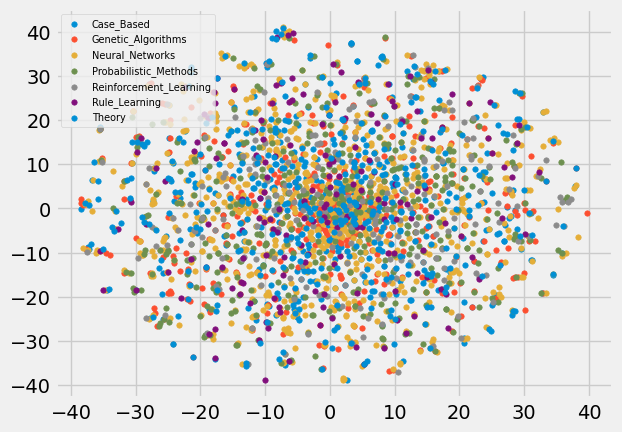

In [9]:
from matplotlib import pyplot as plt

plt.style.use('fivethirtyeight')

@torch.no_grad()
def output_vis():
    for i in range(7):
        output_dim_1 = embedding_2[y == i, 0]
        output_dim_2 = embedding_2[y == i, 1]
        label = list(subject_map.keys())[i]
        
        plt.scatter(output_dim_1, output_dim_2, label=label, s=15)

    plt.legend(loc=2, prop={'size': 7})
    plt.show()

output_vis()